# Imports

In [1]:
import os
import pickle
import random
import pathlib
import itertools
import operator
import unicodedata

In [2]:
import nltk
import numpy as np

# Constants

In [3]:
PROJECT_DIR = pathlib.Path('~/project').expanduser()
DATA_DIR = PROJECT_DIR / 'data'
CORPUS_ROOT = DATA_DIR / 'sample'

# PickledCorpusReader

In [4]:
DOC_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.json'
PKL_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.pickle'
CAT_PATTERN = r'([a-z_\s]+)/.*'

In [5]:
from nltk.corpus.reader.api import CorpusReader
from nltk.corpus.reader.api import CategorizedCorpusReader

class PickledCorpusReader(CategorizedCorpusReader, CorpusReader):

    def __init__(self, root, fileids=PKL_PATTERN, **kwargs):
        """
        Initialize the corpus reader.  Categorization arguments
        (``cat_pattern``, ``cat_map``, and ``cat_file``) are passed to
        the ``CategorizedCorpusReader`` constructor.  The remaining arguments
        are passed to the ``CorpusReader`` constructor.
        """
        # Add the default category pattern if not passed into the class.
        if not any(key.startswith('cat_') for key in kwargs.keys()):
            kwargs['cat_pattern'] = CAT_PATTERN

        CategorizedCorpusReader.__init__(self, kwargs)
        CorpusReader.__init__(self, root, fileids)

    def _resolve(self, fileids, categories):
        """
        Returns a list of fileids or categories depending on what is passed
        to each internal corpus reader function. This primarily bubbles up to
        the high level ``docs`` method, but is implemented here similar to
        the nltk ``CategorizedPlaintextCorpusReader``.
        """
        if fileids is not None and categories is not None:
            raise ValueError("Specify fileids or categories, not both")

        if categories is not None:
            return self.fileids(categories)
        return fileids

    def docs(self, fileids=None, categories=None):
        """
        Returns the document loaded from a pickled object for every file in
        the corpus. Similar to the BaleenCorpusReader, this uses a generator
        to acheive memory safe iteration.
        """
        # Resolve the fileids and the categories
        fileids = self._resolve(fileids, categories)

        # Create a generator, loading one document into memory at a time.
        for path, enc, fileid in self.abspaths(fileids, True, True):
            with open(path, 'rb') as f:
                yield pickle.load(f)

    def paras(self, fileids=None, categories=None):
        """
        Returns a generator of paragraphs where each paragraph is a list of
        sentences, which is in turn a list of (token, tag) tuples.
        """
        for doc in self.docs(fileids, categories):
            for paragraph in doc:
                yield paragraph

    def sents(self, fileids=None, categories=None):
        """
        Returns a generator of sentences where each sentence is a list of
        (token, tag) tuples.
        """
        for paragraph in self.paras(fileids, categories):
            for sentence in paragraph:
                yield sentence

    def tagged_words(self, fileids=None, categories=None):
        """
        Returns a generator of (token, tag) tuples.
        """
        for sent in self.sents(fileids, categories):
            for token, tag in sent:
                yield token, tag

    def words(self, fileids=None, categories=None):
        """
        Returns a generator of tokens.
        """
        for sent in self.sents(fileids, categories):
            for token, tag in sent:
                yield token

In [6]:
from collections import Counter

corpus = PickledCorpusReader(root=CORPUS_ROOT.as_posix())
words  = Counter(corpus.words())

print(f"{len(words.keys()):,} vocabulary {sum(words.values()):,} word count")

58,748 vocabulary 1,624,862 word count


In [7]:
for category in corpus.categories():

    n_docs = len(corpus.fileids(categories=[category]))
    n_words = sum(1 for word in corpus.words(categories=[category]))

    print("- '{}' contains {:,} docs and {:,} words".format(category, n_docs, n_words))

- 'books' contains 71 docs and 41,438 words
- 'business' contains 389 docs and 222,182 words
- 'cinema' contains 100 docs and 69,153 words
- 'cooking' contains 30 docs and 37,854 words
- 'data_science' contains 41 docs and 31,354 words
- 'design' contains 55 docs and 18,260 words
- 'do_it_yourself' contains 122 docs and 28,050 words
- 'gaming' contains 128 docs and 70,778 words
- 'news' contains 1,159 docs and 850,688 words
- 'politics' contains 149 docs and 88,853 words
- 'sports' contains 118 docs and 68,884 words
- 'tech' contains 176 docs and 97,368 words


# Unsupervised Learning on Text

# Clustering by Document Similarity

## Distance Metrics

## Partitive Clustering

### k-means clustering

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

In [9]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

class TextNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self, language='english',
                 join=True, return_generator=True):
        self.language = language
        self.stopwords = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()
        self.join = join
        self.return_generator = return_generator

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P') for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords

    def normalize(self, document):
        return [
            self.lemmatize(token, tag).lower()
            for paragraph in document
            for sentence in paragraph
            for (token, tag) in sentence
            if not self.is_punct(token)
            and not self.is_stopword(token)
        ]

    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

    def fit(self, documents, labels=None):
        return self
    
    def transform(self, documents):
        normalized = map(self.normalize, documents)
        if self.join:
            normalized = map(' '.join, normalized)
        if not self.return_generator:
            normalized = list(normalized)
        return normalized

In [10]:
class DenseTransformer(BaseEstimator, TransformerMixin):
    """Transforms sparse to dense"""

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.toarray()

In [11]:
class ListTransformer(BaseEstimator, TransformerMixin):
    """Transforms 2D array to list of 1D arrays"""

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return list(X)

In [12]:
from nltk.cluster import KMeansClusterer

class KMeansClusters(BaseEstimator):
    """sklearn wrapper for nltk.cluster.KMeansClusterer"""
    
    def __init__(self, k, distance, random_state=None):
        """
        k is the number of clusters
        model is the implementation of Kmeans
        """
        self.k = k
        self.distance = distance
        self.random_state = random_state
        self.model = KMeansClusterer(num_means=self.k,
                                     distance=self.distance,
                                     rng=random.Random(self.random_state),
                                     avoid_empty_clusters=True)
        
    def fit(self, documents, labels=None):
        """
        Fits the K-Means model to one-hot vectorized documents.
        """
        self.model.cluster(documents)
        return self
    
    def predict(self, documents):
        """
        Predicts the closest cluster for each document in documents.
        """
        return list(map(self.model.classify, documents))
    
    def fit_predict(self, documents, labels=None):
        """Calls fit() and predict() methods"""
        return self.fit(documents).predict(documents)

In [13]:
pipeline = Pipeline([
    ('normalizer', TextNormalizer()),
    ('vectorizer', CountVectorizer(lowercase=False,
                                   binary=True,
                                   dtype='short')),
    ('dense_transformer', DenseTransformer()),
    ('list_transformer', ListTransformer()),
    ('clusters', KMeansClusters(k=7,
                                distance=nltk.cluster.util.cosine_distance,
                                random_state=42)),
])

In [14]:
documents = corpus.docs(categories=['news'])

In [15]:
%%time
%%capture
clusters = pipeline.fit_predict(documents)

CPU times: user 11.7 s, sys: 122 ms, total: 11.8 s
Wall time: 12.2 s


In [16]:
# Classify documents in the new corpus by cluster affinity
fileids = corpus.fileids(categories=['news'])
clusters = pipeline.predict(corpus.docs(fileids=fileids))
groups = list(zip(clusters, fileids))

In [17]:
# Group documents in corpus by cluster and display them
groups.sort(key=operator.itemgetter(0))
for group, items in itertools.groupby(groups, key=operator.itemgetter(0)):
    for cluster, fname in items:
        print(f"Cluster {cluster + 1}: {fname}")
        break

Cluster 1: news/56d63af0c1808113ffb88745.pickle
Cluster 2: news/56d7503fc18081081a6e1e15.pickle
Cluster 3: news/56d62570c1808113ffb87557.pickle
Cluster 4: news/56d75003c18081081a6e1b5e.pickle
Cluster 5: news/56d62554c1808113ffb87492.pickle
Cluster 6: news/56d64c7ac1808115036122b4.pickle
Cluster 7: news/56d6255dc1808113ffb874f0.pickle


### Optimizing k-means

In [18]:
from sklearn.cluster import MiniBatchKMeans

In [19]:
pipeline = Pipeline([
    ('normalizer', TextNormalizer()),
    ('vectorizer', CountVectorizer(lowercase=False,
                                   binary=True,
                                   dtype='short')),
    ('clusters', MiniBatchKMeans(n_clusters=7,
                                 random_state=42)),
])

In [20]:
documents = corpus.docs(categories=['news'])

In [21]:
%%time
%%capture
clusters = pipeline.fit_predict(documents)

CPU times: user 2.88 s, sys: 116 ms, total: 2.99 s
Wall time: 2.41 s


In [22]:
# Classify documents in the new corpus by cluster affinity
fileids = corpus.fileids(categories=['news'])
clusters = pipeline.predict(corpus.docs(fileids=fileids))
groups = list(zip(clusters, fileids))

In [23]:
# Group documents in corpus by cluster and display them
groups.sort(key=operator.itemgetter(0))
for group, items in itertools.groupby(groups, key=operator.itemgetter(0)):
    for cluster, fname in items:
        print(f"Cluster {cluster + 1}: {fname}")
        break

Cluster 1: news/56feb305c1808103d32f4279.pickle
Cluster 2: news/57451fb9c180810be6eeb3b5.pickle
Cluster 3: news/5700f2edc1808103d3333520.pickle
Cluster 4: news/571ebb0ec1808103a0dcb387.pickle
Cluster 5: news/5716a55ec1808103a0d08af3.pickle
Cluster 6: news/56d62570c1808113ffb87557.pickle
Cluster 7: news/56d62554c1808113ffb87492.pickle


### Handling uneven geometries

## Hierarchical Clustering

### Agglomerative clustering I

In [24]:
from sklearn.cluster import AgglomerativeClustering

In [25]:
pipeline = Pipeline([
    ('normalizer', TextNormalizer()),
    ('vectorizer', CountVectorizer(lowercase=False,
                                   binary=True,
                                   dtype='short')),
    ('dense_transformer', DenseTransformer()),
    ('clusters', AgglomerativeClustering()),
])

In [26]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [27]:
%%time
%%capture
pipeline.fit(documents)

CPU times: user 8.03 s, sys: 171 ms, total: 8.2 s
Wall time: 8.58 s


In [28]:
clusters = pipeline['clusters'].labels_
groups = list(zip(clusters, fileids))

In [29]:
# Group documents in corpus by cluster and display them
groups.sort(key=operator.itemgetter(0))
for group, items in itertools.groupby(groups, key=operator.itemgetter(0)):
    for cluster, fname in items:
        print(f"Cluster {cluster + 1}: {fname}")
        break

Cluster 1: news/56d6255dc1808113ffb874f0.pickle
Cluster 2: news/56d62554c1808113ffb87492.pickle


In [30]:
documents = corpus.docs(fileids=fileids)

In [31]:
from collections import Counter

labels = [
    [item for item, count in Counter(document.split(' ')).most_common(10)]
    for document in pipeline['normalizer'].transform(documents)
]

In [32]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Distances between each pair of children
    distance = position = np.arange(len(model.children_))
    
    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack((
       model.children_, distance, position
    )).astype('float')
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.tick_params(axis='x', bottom='off', top='off', labelbottom='off')
    plt.tight_layout()

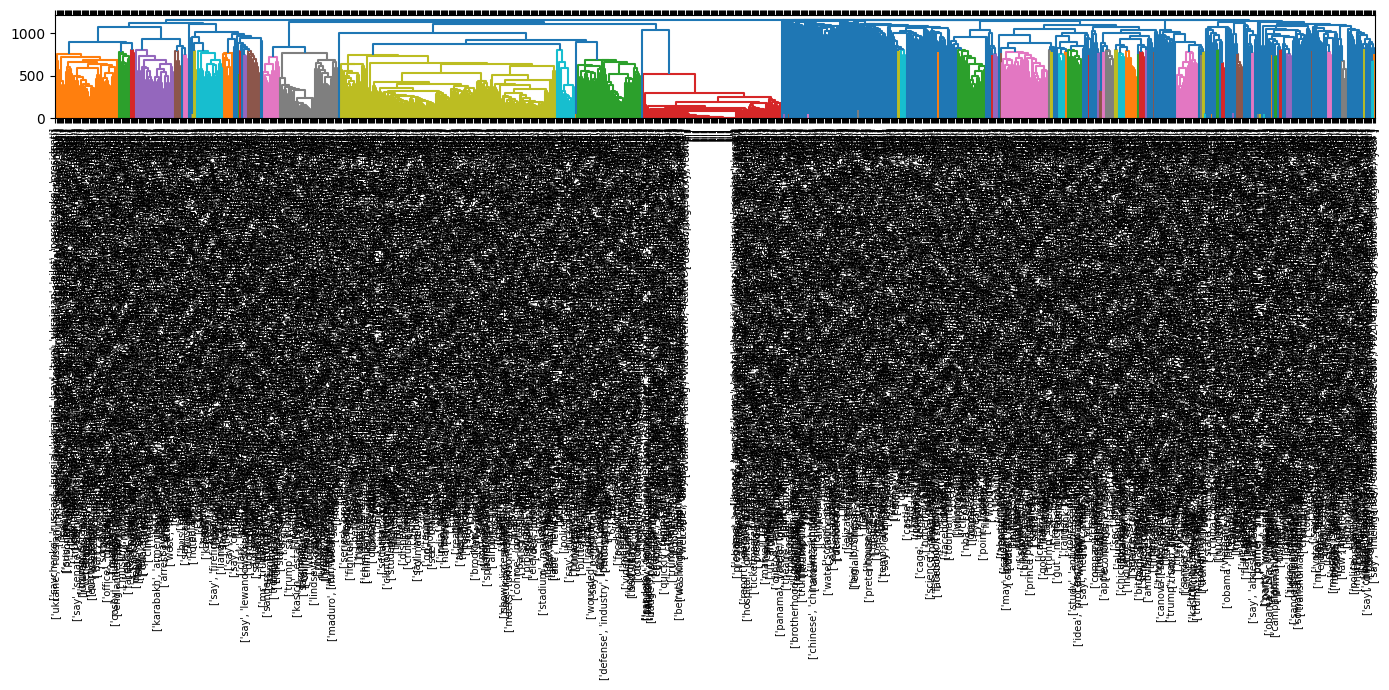

In [33]:
plt.figure(figsize=(14, 7))
plot_dendrogram(model=pipeline['clusters'], 
                labels=labels, 
                leaf_font_size=7)
plt.show()

### Agglomerative clustering II

In [34]:
from sklearn.cluster import AgglomerativeClustering

In [35]:
pipeline = Pipeline([
    ('normalizer', TextNormalizer()),
    ('vectorizer', CountVectorizer(lowercase=False,
                                   binary=True,
                                   dtype='short')),
    ('dense_transformer', DenseTransformer()),
    # setting distance_threshold=0 ensures we compute the full tree
    ('clusters', AgglomerativeClustering(distance_threshold=0,
                                         n_clusters=None)),
])

In [36]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [37]:
%%time
%%capture
pipeline.fit(documents)

CPU times: user 8.03 s, sys: 148 ms, total: 8.17 s
Wall time: 8.56 s


In [38]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(len(model.children_))
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.tight_layout()

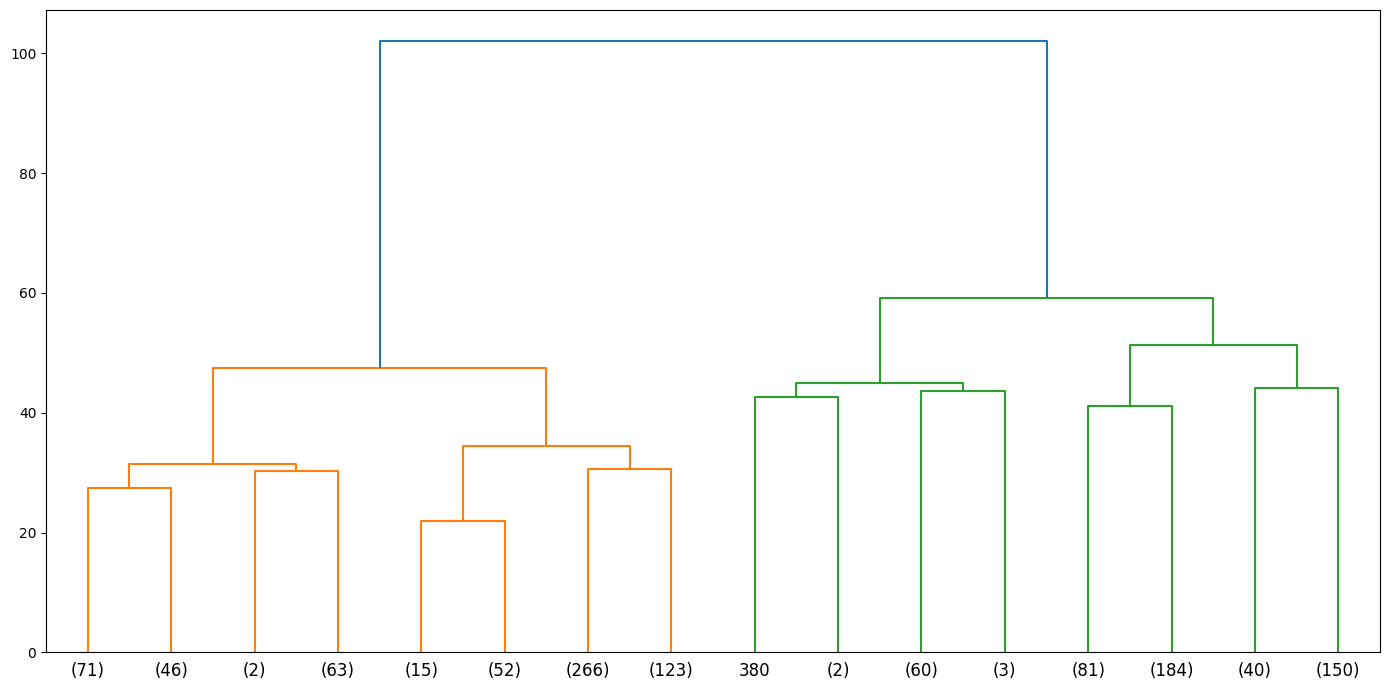

In [39]:
plt.figure(figsize=(14, 7))
plot_dendrogram(model=pipeline['clusters'], 
                truncate_mode="level", p=3)
plt.show()

# Modeling Document Topics

## Latent Dirichlet Allocation

### In Scikit-Learn

In [40]:
from sklearn.decomposition import LatentDirichletAllocation

In [41]:
class LegacyCountVectorizer(CountVectorizer):
    """Add legacy method for pyLDAvis"""
    
    def get_feature_names(self):
        return self.get_feature_names_out()

In [42]:
pipeline = Pipeline([
    ('features', Pipeline([
        ('normalizer', TextNormalizer()),
        # LDA works with counts
        ('vectorizer', LegacyCountVectorizer(lowercase=False)),
    ])),
    ('model', LatentDirichletAllocation(n_components=50,
                                        n_jobs=-1,
                                        random_state=42)),
])

In [43]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [44]:
%%time
%%capture
pipeline.fit(documents)

CPU times: user 2.64 s, sys: 1.09 s, total: 3.73 s
Wall time: 7.12 s


#### Get topics

In [45]:
def get_topics_sklearn(pipeline, n=25):
    """
    n is the number of top terms to show for each topic
    """
    components = pipeline['model'].components_
    feature_names = (pipeline['features']['vectorizer']
                     .get_feature_names_out())
    return {topic_idx: [feature_names[i] for i in
                        topic.argsort()[-1:-(n + 1):-1]]
            for topic_idx, topic in enumerate(components)}

In [46]:
topics = get_topics_sklearn(pipeline)

In [47]:
for topic, terms in topics.items():
    print(f'Topic #{topic}:')
    print(terms)

Topic #0:
['kava', 'hawi', 'hawaii', 'beach', 'say', 'com', 'use', 'suicide', 'www', 'electric', 'include', 'park', 'patient', 'new', 'antidepressant', 'condition', 'canada', 'doctor', 'island', 'assist', 'assisted', 'gibson', 'hotel', 'study', 'salad']
Topic #1:
['say', 'would', 'new', 'make', 'one', 'get', 'year', 'also', 'rule', 'statement', 'last', 'take', 'fight', 'abortion', 'time', 'tell', 'overtime', 'go', 'state', 'police', 'day', 'bill', 'see', 'people', 'law']
Topic #2:
['bergdahl', 'say', 'prison', 'koenig', 'year', 'would', 'case', 'one', 'episode', 'time', 'court', 'also', 'tell', 'sentence', 'take', 'soldier', 'know', 'two', 'family', 'guzmán', 'hastert', 'go', 'could', 'day', 'home']
Topic #3:
['get', 'go', 'like', 'make', 'stepanov', 'use', 'two', 'time', 'transit', 'keteyian', 'armen', 'eat', 'russia', 'take', 'vitaly', 'year', 'anti', 'mercury', 'pension', 'food', 'dope', 'say', 'also', 'would', 'ftc']
Topic #4:
['mr', 'house', 'say', 'president', 'party', 'year', 'o

#### Get top topic

In [48]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [49]:
%%time
pipeline.transform(documents).argmax(axis=1)

CPU times: user 1.67 s, sys: 74.1 ms, total: 1.74 s
Wall time: 2.31 s


array([ 2, 24, 22, ...,  0, 28,  0])

#### Visualize topics

In [51]:
import pyLDAvis
import pyLDAvis.sklearn as sklearnvis

In [52]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [53]:
model = pipeline['model']
features = pipeline['features'].transform(documents)
vectorizer = pipeline['features']['vectorizer']

In [54]:
%%time
%%capture
data = sklearnvis.prepare(model, features, vectorizer)

CPU times: user 829 ms, sys: 67.9 ms, total: 897 ms
Wall time: 3.34 s


In [55]:
# pyLDAvis.display(data)

### The Gensim way

In [57]:
from gensim.matutils import sparse2full
from gensim.corpora import Dictionary

In [58]:
from gensim.sklearn_api import ldamodel

In [59]:
class GensimCountVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, dirpath=".", tofull=False):
        """
        Pass in a directory that holds the lexicon in corpus.dict.

        Set tofull = True if the next thing is a Scikit-Learn estimator
        otherwise keep False if the next thing is a Gensim model.
        """
        self.dirpath = dirpath
        self._lexicon_path = os.path.join(dirpath, "corpus.dict")

        self.lexicon = None
        self.tofull = tofull

        self.load()

    def load(self):
        if os.path.exists(self._lexicon_path):
            self.lexicon = Dictionary.load(self._lexicon_path)

    def save(self):
        self.lexicon.save(self._lexicon_path)

    def fit(self, documents, labels=None):
        self.lexicon = Dictionary(documents)
        self.save()
        return self

    def transform(self, documents):
        def generator():
            for document in documents:
                vec = self.lexicon.doc2bow(document)
                if self.tofull:
                    yield sparse2full(vec)
                else:
                    yield vec
        return list(generator())

In [60]:
pipeline = Pipeline([
    ('features', Pipeline([
        ('normalizer', TextNormalizer(join=False,
                                      return_generator=False)),
        # LDA works with counts
        ('vectorizer', GensimCountVectorizer()),
    ])),
    ('model', ldamodel.LdaTransformer(num_topics=50,
                                      random_state=42)),
])

In [61]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [62]:
%%time
%%capture
pipeline.fit(documents)

CPU times: user 40.1 s, sys: 111 ms, total: 40.2 s
Wall time: 7.11 s


#### Get topics

In [63]:
def get_topics_gensim(pipeline, n=25):
    """
    n is the number of top terms to show for each topic
    """
    components = pipeline['model'].gensim_model.get_topics()
    feature_names = pipeline['features']['vectorizer'].lexicon
    return {topic_idx: [feature_names[i] for i in
                        topic.argsort()[-1:-(n + 1):-1]]
            for topic_idx, topic in enumerate(components)}

In [64]:
topics = get_topics_gensim(pipeline)

In [65]:
for topic, terms in topics.items():
    print(f'Topic #{topic}:')
    print(terms)

Topic #0:
['trump', 'say', 'mr', 'one', 'new', 'make', 'like', 'first', 'also', 'people', 'would', 'year', 'cruz', 'tell', 'take', 'time', 'go', 'woman', 'day', 'service', 'get', 'two', 'u', 'president', 'call']
Topic #1:
['say', 'year', 'u', 'two', 'time', 'make', 'would', 'state', 'tell', 'one', 'party', 'people', 'like', 'also', 'new', 'go', 'president', 'last', 'take', 'first', 'country', 'world', 'get', 'could', 'come']
Topic #2:
['say', 'people', 'trump', 'would', 'one', 'take', 'state', 'attack', 'time', 'year', 'come', 'two', 'last', 'new', 'group', 'day', 'republican', 'find', 'police', 'tell', 'law', 'make', 'use', 'party', 'charge']
Topic #3:
['say', 'year', 'would', 'go', 'one', 'get', 'make', 'people', 'u', 'state', 'take', 'time', 'also', 'police', 'trump', 'tell', 'two', 'prince', 'mr', 'know', 'report', 'like', 'last', 'group', 'new']
Topic #4:
['say', 'people', 'new', 'year', 'first', 'trump', 'u', 'state', 'one', 'would', 'take', 'get', 'government', 'group', 'report'

#### Get top topic

In [66]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [67]:
%%time
pipeline.transform(documents).argmax(axis=1)

CPU times: user 13.8 s, sys: 57.1 ms, total: 13.8 s
Wall time: 3.56 s


array([16, 46, 47, ...,  0, 43, 33])

#### Visualize topics

In [68]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [69]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [70]:
model = pipeline['model'].gensim_model
features = pipeline['features'].transform(documents)
lexicon = pipeline['features']['vectorizer'].lexicon

In [71]:
%%time
%%capture
data = gensimvis.prepare(model, features, lexicon)

CPU times: user 12.1 s, sys: 46.1 ms, total: 12.1 s
Wall time: 4.39 s


In [72]:
# pyLDAvis.display(data)

## Latent Semantic Analysis

### In Scikit-Learn

In [73]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

In [74]:
pipeline = Pipeline([
    ('features', Pipeline([
        ('normalizer', TextNormalizer()),
        # tf–idf matrices is recommended over raw frequency counts
        # sublinear scaling and inverse document frequency should be turned on
        # sublinear_tf=True, use_idf=True
        ('vectorizer', TfidfVectorizer(lowercase=False,
                                       use_idf=True,
                                       sublinear_tf=True)),
    ])),
    ('model', TruncatedSVD(n_components=50,
                           random_state=42)),
])

In [75]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [76]:
%%time
%%capture
pipeline.fit(documents)

CPU times: user 6.12 s, sys: 176 ms, total: 6.3 s
Wall time: 2.71 s


#### Get topics

In [77]:
topics = get_topics_sklearn(pipeline)

In [78]:
for topic, terms in topics.items():
    print(f'Topic #{topic}:')
    print(terms)

Topic #0:
['say', 'trump', 'year', 'one', 'would', 'people', 'make', 'state', 'new', 'go', 'also', 'time', 'get', 'take', 'two', 'tell', 'like', 'last', 'first', 'could', 'come', 'know', 'president', 'day', 'report']
Topic #1:
['trump', 'republican', 'cruz', 'delegate', 'donald', 'clinton', 'candidate', 'sanders', 'primary', 'kasich', 'presidential', 'campaign', 'convention', 'vote', 'gop', 'party', 'nominee', 'nomination', 'ted', 'hillary', 'democratic', 'race', 'win', 'voter', 'poll']
Topic #2:
['police', 'attack', 'kill', 'official', 'syria', 'state', 'military', 'security', 'report', 'government', 'force', 'minister', 'islamic', 'say', 'turkey', 'al', 'group', 'bomb', 'authority', 'syrian', 'brussels', 'country', 'iran', 'terrorist', 'president']
Topic #3:
['police', 'county', 'man', 'night', 'shoot', 'saturday', 'old', 'say', 'cbs', 'home', 'kill', 'play', 'suspect', 'cruz', 'shooting', 'game', 'die', 'trump', 'victim', 'three', 'hospital', 'prince', 'shot', 'death', 'sheriff']
To

#### Get top topic

In [79]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [80]:
%%time
pipeline.transform(documents).argmax(axis=1)

CPU times: user 1.69 s, sys: 53 ms, total: 1.74 s
Wall time: 2.15 s


array([0, 0, 0, ..., 0, 0, 0])

### The Gensim way

In [81]:
import gensim

In [82]:
from gensim.matutils import sparse2full
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel

In [83]:
from gensim.sklearn_api import lsimodel

In [84]:
class GensimTfidfVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, dirpath=".", tofull=False):
        """
        Pass in a directory that holds the lexicon in corpus.dict and the
        TFIDF model in tfidf.model (for now).

        Set tofull = True if the next thing is a Scikit-Learn estimator
        otherwise keep False if the next thing is a Gensim model.
        """
        self.dirpath = dirpath
        self._lexicon_path = os.path.join(dirpath, "corpus.dict")
        self._tfidf_path = os.path.join(dirpath, "tfidf.model")

        self.lexicon = None
        self.tfidf = None
        self.tofull = tofull

        self.load()

    def load(self):
        if os.path.exists(self._lexicon_path):
            self.lexicon = Dictionary.load(self._lexicon_path)

        if os.path.exists(self._tfidf_path):
            self.tfidf = TfidfModel().load(self._tfidf_path)

    def save(self):
        self.lexicon.save(self._lexicon_path)
        self.tfidf.save(self._tfidf_path)

    def fit(self, documents, labels=None):
        self.lexicon = Dictionary(documents)
        self.tfidf = TfidfModel(corpus=[self.lexicon.doc2bow(doc)
                                        for doc in documents],
                                id2word=self.lexicon)
        self.save()
        return self

    def transform(self, documents):
        def generator():
            for document in documents:
                vec = self.tfidf[self.lexicon.doc2bow(document)]
                if self.tofull:
                    yield sparse2full(vec)
                else:
                    yield vec
        return list(generator())

In [85]:
pipeline = Pipeline([
    ('features', Pipeline([
        ('normalizer', TextNormalizer(join=False,
                                      return_generator=False)),
        ('vectorizer', GensimTfidfVectorizer()),
    ])),
    ('model', lsimodel.LsiTransformer(num_topics=50)),
])

In [86]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [87]:
%%time
%%capture
pipeline.fit(documents)

CPU times: user 10.8 s, sys: 242 ms, total: 11 s
Wall time: 3.89 s


#### Get topics

In [88]:
topics = get_topics_gensim(pipeline)

In [89]:
for topic, terms in topics.items():
    print(f'Topic #{topic}:')
    print(terms)

Topic #0:
['trump', 'cruz', 'clinton', 'delegate', 'sanders', 'republican', 'party', 'campaign', 'mr', 'candidate', 'state', 'vote', 'donald', 'kasich', 'primary', 'obama', 'convention', 'presidential', 'say', 'president', 'gop', 'u', 'voter', 'win', 'new']
Topic #1:
['police', 'school', 'turkey', 'prince', 'china', 'military', 'government', 'company', 'official', 'report', 'refugee', 'brussels', '$', 'migrant', 'kill', 'attack', 'u', 'city', 'department', 'year', 'say', 'force', 'syria', 'car', 'fire']
Topic #2:
['turkey', 'migrant', 'refugee', 'greece', 'eu', 'turkish', 'border', 'brussels', 'syrian', 'attack', 'trump', 'syria', 'camp', 'abdeslam', 'greek', 'police', 'belgian', 'europe', 'lesbos', 'paris', 'asylum', 'macedonia', 'iran', 'islamic', 'boat']
Topic #3:
['sanders', 'clinton', 'democratic', 'bernie', 'obama', 'hillary', 'michigan', 'voter', 'vote', 'primary', 'delegate', 'party', 'tax', 'president', 'iran', 'democrats', 'campaign', 'state', 'qualify', 'states', 'vermont', 

#### Get top topic

In [90]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [91]:
%%time
pipeline.transform(documents).argmax(axis=1)

CPU times: user 1.86 s, sys: 54.4 ms, total: 1.92 s
Wall time: 2.3 s


array([ 0,  0,  1, ...,  0, 23,  0])

## Non-Negative Matrix Factorization

### In Scikit-Learn

In [92]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

In [93]:
pipeline = Pipeline([
    ('features', Pipeline([
        ('normalizer', TextNormalizer()),
        ('vectorizer', TfidfVectorizer(lowercase=False,
                                       use_idf=True,
                                       sublinear_tf=True)),
    ])),
    ('model', NMF(n_components=50,
                  random_state=42)),
])

In [94]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [95]:
%%time
%%capture
pipeline.fit(documents)

CPU times: user 23.4 s, sys: 217 ms, total: 23.6 s
Wall time: 18.8 s


#### Get topics

In [96]:
topics = get_topics_sklearn(pipeline)

In [97]:
for topic, terms in topics.items():
    print(f'Topic #{topic}:')
    print(terms)

Topic #0:
['like', 'think', 'way', 'life', 'thing', 'really', 'want', 'get', 'something', 'know', 'feel', 'go', 'never', 'always', 'even', 'see', 'one', 'make', 'time', 'good', 'look', 'much', 'work', 'every', 'love']
Topic #1:
['cruz', 'delegate', 'trump', 'kasich', 'convention', 'ted', 'republican', 'gop', 'nomination', 'donald', 'primary', 'ohio', 'candidate', 'john', 'gov', 'win', 'campaign', 'sen', 'state', 'indiana', 'vote', 'race', 'presidential', 'rubio', 'poll']
Topic #2:
['iraq', 'isis', '52s', 'force', 'air', 'iraqi', 'battlefield', 'pentagon', 'precision', 'bomb', '52', 'bomber', 'syria', 'loiter', 'kurdish', 'military', 'supersonic', 'forces', 'command', 'lt', 'coalition', 'al', 'base', 'abadi', 'afghanistan']
Topic #3:
['police', 'county', 'fire', 'officer', 'firefighter', 'say', 'department', 'hospital', 'home', 'shooting', 'shoot', 'man', 'shooter', 'stawinski', 'maryland', 'injure', 'sheriff', 'inside', 'immediately', 'accord', 'suspect', 'outside', 'custody', 'person'

#### Get top topic

In [98]:
fileids = corpus.fileids(categories=['news'])
documents = corpus.docs(fileids=fileids)

In [99]:
%%time
pipeline.transform(documents).argmax(axis=1)

CPU times: user 1.8 s, sys: 46.8 ms, total: 1.85 s
Wall time: 2.23 s


array([21, 42,  3, ...,  0, 28, 27])